<a href="https://colab.research.google.com/github/djjay0131/cs5804-mini-project/blob/master/vulnerability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install gdown

In [ ]:
import pandas as pd
import io
import zipfile
import gdown
import torch
from tqdm import tqdm
import numpy as np

from transformers import AutoTokenizer

import string
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from keras.utils import plot_model

from sklearn.model_selection import train_test_split


In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive/')

In [ ]:
CVE_fixes_sharedPath = 'https://drive.google.com/file/d/13HqfT79hp0xr_JwNvwIwNGhszhX5ObMV/view?usp=sharing'
output_path = 'CVEFixes.csv.zip'
gdown.download(CVE_fixes_sharedPath, output_path, quiet=False, fuzzy=True)

In [ ]:
# data_path = '/content/drive/MyDrive/Fall 2023/CS5804/cs-5804-mini-project/data'
data_path = output_path

In [ ]:
# !ls '/content/drive/MyDrive/Fall 2023/CS5804/cs-5804-mini-project/data'
!ls

CVEFixes.csv.zip  lstm_autoencoder.png	sample_data


In [ ]:
# zip_file = data_path + '/CVEFixes.csv.zip'
zip_file = data_path
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
!ls '/tmp'

__autograph_generated_file27s28xhl.py
__autograph_generated_file311wx2io.py
__autograph_generated_fileabj3c29h.py
__autograph_generated_filega2kumr_.py
__autograph_generated_fileim44cnox.py
__autograph_generated_fileo7dmsjm_.py
CVEFixes.csv
dap_multiplexer.236716539e4d.root.log.INFO.20231126-184758.104
dap_multiplexer.INFO
debugger_2dxjb90n95
initgoogle_syslog_dir.0
language_service.236716539e4d.root.log.ERROR.20231126-185449.1241
language_service.236716539e4d.root.log.ERROR.20231126-200918.18314
language_service.236716539e4d.root.log.ERROR.20231126-201305.21497
language_service.236716539e4d.root.log.ERROR.20231126-205856.27837
language_service.236716539e4d.root.log.ERROR.20231126-222222.33489
language_service.236716539e4d.root.log.INFO.20231126-185155.1115
language_service.236716539e4d.root.log.INFO.20231126-185208.1201
language_service.236716539e4d.root.log.INFO.20231126-185213.1241
language_service.236716539e4d.root.log.INFO.20231126-195959.18314
language_service.236716539e4d.root.l

In [ ]:
df = pd.read_csv('/tmp/CVEFixes.csv')
df.head()

,code,language,safety
0,package org.bouncycastle.jcajce.provider.asymm...,java,vulnerable
1,<?php\n\n\n\n/**\n\n * ownCloud - user_ldap\n\...,php,vulnerable
2,#!/usr/bin/env python\n\nfrom __future__ impor...,py,safe
3,/* -*- c-basic-offset: 8 -*-\n\n rdesktop: A...,c,safe
4,<!DOCTYPE html>\n\n<html>\n\n <head>\n\n ...,html,safe


In [ ]:
df.describe()

,code,language,safety
count,31160,31194,31194
unique,23557,48,2
top,404: Not Found,c,vulnerable
freq,1447,8632,15597


In [ ]:
df['language'].value_counts()

c           8632
Other       6122
php         5590
py          1564
js          1562
h           1344
java        1162
rb          1120
cpp          626
go           464
cc           360
html         266
xml          252
cs           220
json         220
tpl          170
pm           144
sh           132
phpt         102
ts           100
m             70
inc           62
scala         60
ctp           58
cxx           54
t             50
jsp           50
jelly         44
yml           44
yaml          38
coffee        34
pl            34
spec          32
tt            32
rs            32
scss          32
htaccess      32
S             32
as            30
conf          30
vim           28
hh            26
lua           26
sql           24
css           24
cgi           22
phtml         22
htm           20
Name: language, dtype: int64

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda:0")

In [ ]:
tqdm.pandas()

## Uncomment the line below to run only sample

In [ ]:
df_copy = df.copy()
# df_copy = df.iloc[:100, :].copy()

df_copy.shape

(31194, 3)

In [ ]:
# removing punctuations, spaces, etc - might not be needed. Will try both ways and see.
df_copy['code'] = df_copy['code'].progress_apply(lambda x: str(x))


# tokenize and encode
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
def tokenize_function(code):
  tokens = tokenizer.tokenize(code)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  return token_ids
  # return tokenizer.encode(code, truncation=True, padding="max_length", max_length=512)

def ids_to_tokens(token_ids):
    return tokenizer.convert_ids_to_tokens(token_ids)

# Function to join tokens back into a string
def tokens_to_string(tokens):
    return tokenizer.convert_tokens_to_string(tokens)


df_copy['code_tokenIDs']=df_copy['code'].progress_apply(lambda x: tokenize_function(x))



100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


In [ ]:
df_copy['code_tokenIDs']

0     [7305, 8916, 119, 171, 6094, 7232, 26487, 119,...
1     [133, 136, 185, 16194, 120, 115, 115, 115, 131...
2     [108, 106, 120, 1366, 1197, 120, 9055, 120, 40...
3     [120, 115, 118, 115, 118, 172, 118, 3501, 118,...
4     [133, 106, 141, 9244, 16880, 2101, 2036, 28066...
                            ...                        
95    [1383, 113, 138, 12152, 3048, 2240, 168, 5833,...
96                            [27993, 131, 1753, 17107]
97    [133, 136, 185, 16194, 120, 115, 115, 22359, 1...
98    [120, 115, 115, 115, 115, 115, 115, 115, 115, ...
99    [120, 115, 115, 23232, 2101, 131, 1760, 7249, ...
Name: code_tokenIDs, Length: 100, dtype: object

In [ ]:
# check that id conversion worked
ids = df_copy['code_tokenIDs'][80]
decoded_string = tokenizer.decode(ids)
print(decoded_string)

# Changelog # # # Major Changes - Version 4 * * New Functions * * - ` chassis ( ) ` : chassis information * * Breaking Changes * * - ` networkStats ( ) ` : will provide an * * array * * of stats for all given interfaces. In previous versions only one interface was provided as a parameter. Pass'*'for all interfaces - ` networkStats ( ) ` : ` rx ` and ` tx ` changed to ` rx _ bytes ` and ` tx _ bytes ` - ` dockerContainerStats ( ) ` : will provide an * * array * * of stats for all given docker containers. In previous versions only one interface was provided as a parameter. Pass'*'for all docker containers * * Other Changes * * - ` system ( ) ` optimized system detection ( e. g. new Raspberry Pi models,... ) - ` system ( ) `, ` bios ( ) `, ` baseboard ( ) ` information also as non - root ( linux ) - ` graphics ( ) ` better controller and display detection, fixes - ` versions ( ) ` optimization, fixes - ` networkInterfaces ( ) ` added ` operstate `, ` type `, ` duplex `, ` mtu `, ` speed `

In [ ]:
# maximum sequence length - default value might be too large for now
max_Length = max(df_copy['code'].progress_apply(lambda x: len(x)))
print(max_Length)

max_Length = 50

padded_sequences = pad_sequences(df_copy['code_tokenIDs'], maxlen= max_Length, padding='post')

# categorical labels
label_dict = {'safe': 0, 'vulnerable': 1}
numerical_labels = [label_dict[label] for label in df_copy['safety']]
labels = to_categorical(numerical_labels)

X= np.reshape(padded_sequences, (padded_sequences.shape[0], max_Length, 1))
y= labels

100%|██████████| 100/100 [00:00<00:00, 87199.67it/s]

256496


In [ ]:
# train test split
X_train, X_test = train_test_split(
    X,test_size=0.2, random_state=42)

In [ ]:
# https://machinelearningmastery.com/lstm-autoencoders/


In [ ]:
# some parameters
X.shape
steps= X.shape[1]
feature_size = X.shape[2]
latent_size = 250



In [ ]:
# models
# encoder aspect
model = Sequential()
model.add(LSTM(latent_size, input_shape=(steps, feature_size), return_sequences=False))
model.add(RepeatVector(steps))

# decoder aspect
model.add(LSTM (latent_size, return_sequences= True))
model.add (TimeDistributed(Dense(feature_size)))

model.compile(optimizer='adam', loss='mse')

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 250)               252000    
                                                                 
 repeat_vector_4 (RepeatVec  (None, 50, 250)           0         
 tor)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 50, 250)           501000    
                                                                 
 time_distributed_4 (TimeDi  (None, 50, 1)             251       
 stributed)                                                      
                                                                 
Total params: 753251 (2.87 MB)
Trainable params: 753251 (2.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train, X_train, epochs=10, batch_size=128, validation_split = 0.2)

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 46123264.0000 - val_loss: 41117692.0000
Epoch 2/10
1/1 [==============================] - 0s 134ms/step - loss: 46108336.0000 - val_loss: 41105664.0000
Epoch 3/10
1/1 [==============================] - 0s 85ms/step - loss: 46094908.0000 - val_loss: 41095160.0000
Epoch 4/10
1/1 [==============================] - 0s 104ms/step - loss: 46083344.0000 - val_loss: 41086200.0000
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 46073660.0000 - val_loss: 41078288.0000
Epoch 6/10
1/1 [==============================] - 0s 54ms/step - loss: 46065304.0000 - val_loss: 41070832.0000
Epoch 7/10
1/1 [==============================] - 0s 48ms/step - loss: 46057544.0000 - val_loss: 41063484.0000
Epoch 8/10
1/1 [==============================] - 0s 52ms/step - loss: 46049916.0000 - val_loss: 41056232.0000
Epoch 9/10
1/1 [==============================] - 0s 47ms/step - loss: 46042332.0000 - val_loss: 41049192.0000

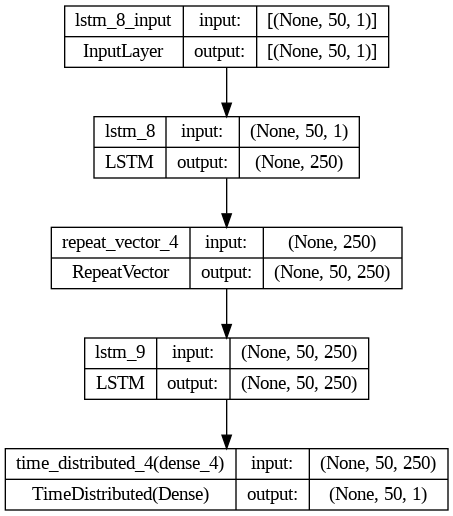

In [ ]:
# visualizing the model
plot_model(model, show_shapes=True, to_file='lstm_autoencoder.png')

In [ ]:
def ids_to_text(sequence, id_to_word):
  return ' '.join([id_to_word.get(id, '<UNK>') for id in sequence])

# compraring to sample of test data
test_data= X_test[:2,:,:]


# Make predictions
predicted_sequences = model.predict(test_data)


# Convert predictions back to text
for i, sequence in enumerate(predicted_sequences):
    tokens = ids_to_tokens(sequence)

    predicted_text = tokens_to_string(tokens)

    original_tokens = ids_to_tokens(df_copy['code_tokenIDs'].iloc[i])
    original_text = tokens_to_string(original_tokens)

    print(f"Original: {original_text}")
    print(f"Predicted: {predicted_text}\n")

for i, sequence in enumerate(predicted_sequences):

    tokens = ids_to_tokens(sequence)

    # converting tokens to a single string
    predicted_text = tokens_to_string(tokens)

    original_tokens = ids_to_tokens(df_copy['code_tokenIDs'].iloc[i])
    original_text = tokens_to_string(original_tokens)

    print(f"Original: {original_text}")
    print(f"Predicted: {predicted_text}\n")


1/1 [==============================] - 1s 936ms/step
Original: package org. bouncycastle. jcajce. provider. asymmetric. dsa ; import java. security. InvalidAlgorithmParameterException ; import java. security. InvalidParameterException ; import java. security. KeyPair ; import java. security. SecureRandom ; import java. security. spec. AlgorithmParameterSpec ; import java. security. spec. DSAParameterSpec ; import org. bouncycastle. crypto. AsymmetricCipherKeyPair ; import org. bouncycastle. crypto. generators. DSAKeyPairGenerator ; import org. bouncycastle. crypto. generators. DSAParametersGenerator ; import org. bouncycastle. crypto. params. DSAKeyGenerationParameters ; import org. bouncycastle. crypto. params. DSAParameters ; import org. bouncycastle. crypto. params. DSAPrivateKeyParameters ; import org. bouncycastle. crypto. params. DSAPublicKeyParameters ; public class KeyPairGeneratorSpi extends java. security. KeyPairGenerator { DSAKeyGenerationParameters param ; DSAKeyPairGenera